In [1]:
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torchvision.transforms import v2

In [3]:
scaling = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float32, scale=True)
]
)
train_data = datasets.MNIST('./data', train=True, download=True,
                            transform=scaling)

data = train_data.data
labels = train_data.targets
print(f'There are {len(data)} observations - each represent image of 28x28.')

100%|██████████| 9.91M/9.91M [00:00<00:00, 21.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.39MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.15MB/s]


There are 60000 observations - each represent image of 28x28.


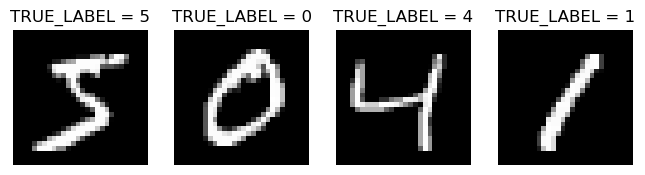

In [ ]:
#========================================
# PART A
#========================================

single_plot = lambda x: plt.imshow(x, cmap="gray")
# single_plot(data[0])

def plot_images(k : int):
    fig, ax = plt.subplots(1,k,figsize=(8,8*8))
    for i in range(k):
        ax[i].imshow(data[i],cmap="gray")
        ax[i].set_title(f'TRUE_LABEL = {labels[i]}')
        ax[i].axis("off")

plot_images(4)

In [ ]:
#========================================
# PART B
#========================================

filtered_data, filtered_labels = data[:10_000], labels[:10_000]
flattened_data = data.flatten(start_dim=1) # flatten to vector

def normalize(arr : torch.tensor):
    min_, max_ = arr.min(), arr.max()
    diff = max_ - min_
    if diff == 0:
        return torch.zeros_like(arr)
    return (arr - min_) / diff

normalized_data = torch.stack([normalize(x) for x in flattened_data])

In [ ]:
#========================================
# PART C
#========================================

